!pip install torch
!pip install torchvision
!pip install torch

## Convolutional Neural Network is a type of neural network which uses a special operation called convolution.

And it works best when we have image data.

A typical pipeline of CNN looks like this.

Input -> Convolutional layer -> Pooling layer -> Add non-linearity ( adding regularization and 
                                                                    activation functions)

-> Fully connected layers -> Ouput

There is a lot of preprocessing methods that can be used in between this pipeline. 

Convolution is a multiplication operation between an input and a filter. It's not a simple multiplication
process, rather, it is computed by multiplying the input with the filter over a delayed period of time


Input * filter -> Answer

In CNN,

filter


filter = [[1,1,1],
          [0,0,0],
          [1,1,1]]

filter2 = [[-1,-1,-1],[0,0,0],[-1,-1,-1]]


Steps :

step 1 : Load the image dataset.
step 2 : preprocessing the image dataset
step 3 : Then we define the resnet50 architecture and we add a custom layer for training our model
step 4 : We train our model for 5 epochs.
step 5 : We use the trained model to make inference of our test dataset
step 6 : Visualize the results of our data

In [1]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

^C
Note: you may need to restart the kernel to use updated packages.


Looking in indexes: https://download.pytorch.org/whl/cu121
     ---------------------------------------- 0.0/4.1 MB ? eta -:--:--
      --------------------------------------- 0.1/4.1 MB 2.6 MB/s eta 0:00:02
     -- ------------------------------------- 0.2/4.1 MB 3.1 MB/s eta 0:00:02
     --- ------------------------------------ 0.3/4.1 MB 2.9 MB/s eta 0:00:02
     ---- ----------------------------------- 0.4/4.1 MB 2.8 MB/s eta 0:00:02
     ----- ---------------------------------- 0.5/4.1 MB 2.6 MB/s eta 0:00:02
     ------ --------------------------------- 0.6/4.1 MB 2.5 MB/s eta 0:00:02
     ------- -------------------------------- 0.8/4.1 MB 2.6 MB/s eta 0:00:02
     -------- ------------------------------- 0.8/4.1 MB 2.4 MB/s eta 0:00:02
     --------- ------------------------------ 1.0/4.1 MB 2.4 MB/s eta 0:00:02
     ----------- ---------------------------- 1.1/4.1 MB 2.5 MB/s eta 0:00:02
     ------------ --------------------------- 1.3/4.1 MB 2.6 MB/s eta 0:00:02
     -------

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import numpy as np
import os
cwd = os.getcwd()
from PIL import Image
import time
import copy
import random
import cv2
import re
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Load the Cracks Dataset and Visualize it
* Link to the cracks data set:  https://data.mendeley.com/datasets/5y9wdsg2zt/2


In [15]:
crack_images = os.listdir('Positive/')
print("Number of Crack Images: ", len(crack_images))

Number of Crack Images:  5000


In [16]:
no_crack_images = os.listdir('Negative/')
print("Number of No Crack Images: ", len(no_crack_images))

Number of No Crack Images:  5000


*****************Random Images with Cracks**************************


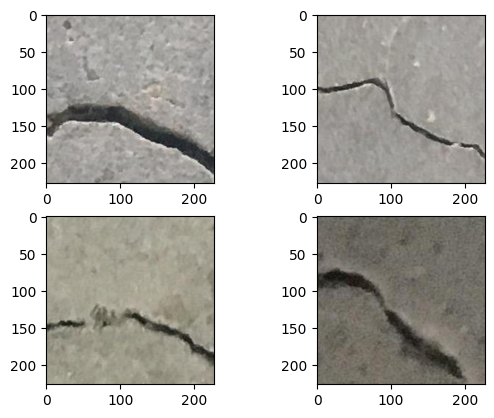

In [17]:
## Visualize Random images with cracks
random_indices = np.random.randint(0, len(crack_images), size=4)
print("*****************Random Images with Cracks**************************")
random_images = np.array(crack_images)[random_indices.astype(int)]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[0])))
axarr[0,1].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[1])))
axarr[1,0].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[2])))
axarr[1,1].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[3])))

*****************Random Images without Cracks**************************


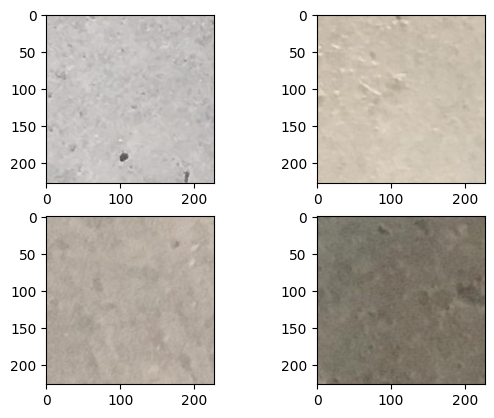

In [18]:
## Visualize Random images with no cracks
random_indices = np.random.randint(0, len(no_crack_images), size=4)
print("*****************Random Images without Cracks**************************")
random_images = np.array(no_crack_images)[random_indices.astype(int)]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[0])))
axarr[0,1].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[1])))
axarr[1,0].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[2])))
axarr[1,1].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[3])))

## Create Train and Val Data sets

### Create training folder

In [19]:
base_dir = cwd
files = os.listdir(base_dir)

def create_training_data(folder_name):
    train_dir = f"{base_dir}/train/{folder_name}"
    for f in files:
        search_object = re.search(folder_name, f)
        if search_object:
            shutil.move(f'{base_dir}/{folder_name}', train_dir)

In [20]:
create_training_data('Positive')
create_training_data('Negative')

### Move images randomly from training to val folders

In [21]:
os.makedirs('val/Positive')
os.makedirs('val/Negative')

In [22]:
positive_train = base_dir + "/train/Positive/"
positive_val = base_dir + "/val/Positive/"
negative_train = base_dir + "/train/Negative/"
negative_val = base_dir + "/val/Negative/"

positive_files = os.listdir(positive_train)
negative_files = os.listdir(negative_train)

In [23]:
print(len(positive_files), len(negative_files))

5000 5000


In [24]:
for f in positive_files:
    if random.random() > 0.80:
        shutil.move(f'{positive_train}/{f}', positive_val)

In [25]:
for f in negative_files:
    if random.random() > 0.80:
        shutil.move(f'{negative_train}/{f}', negative_val)

## Pytorch data loader and transforms

### Compute mean and std deviation for the dataset

In [9]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

# there are three channels in an RGB IMAGE.
# 1. red
# 2. green
# 3. blue

In [8]:
import torchvision.transforms
from torchvision import datasets, models, transforms


In [11]:
## Define data augmentation and transforms
chosen_transforms = {'train': transforms.Compose([
        transforms.RandomResizedCrop(size=227),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'val': transforms.Compose([
        transforms.Resize(227),
        transforms.CenterCrop(227),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]),
}

In [29]:
## Create the data loader
def load_dataset(format, batch_size):
    data_path = os.path.join(cwd, format)
    dataset = datasets.ImageFolder(
        root=data_path,
        transform= chosen_transforms[format]
    )
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        shuffle=True
    )
    return data_loader, len(dataset), dataset.classes

In [30]:
## Set code to run on device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [31]:
train_loader, train_size, class_names = load_dataset('train', 8)
print("Train Data Set size is: ", train_size)
print("Class Names are: ", class_names)
inputs, classes = next(iter(train_loader))
print(inputs.shape, classes.shape)

Train Data Set size is:  7989
Class Names are:  ['Negative', 'Positive']
torch.Size([8, 3, 227, 227]) torch.Size([8])


### Visualize the Augmented Data Set

In [32]:
# Visualize some images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

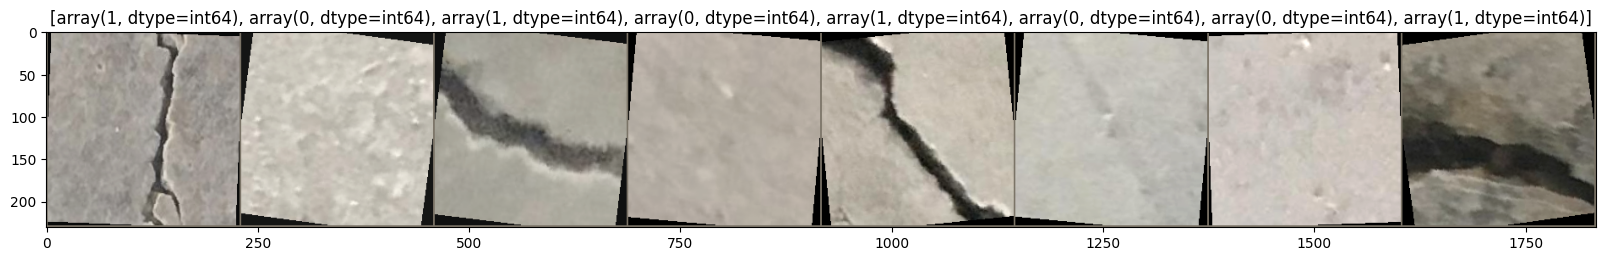

In [33]:
# Grab some of the training data to visualize
inputs, classes = next(iter(train_loader))
# class_names = chosen_datasets['train'].classes
# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

idx_to_class = {0:'Negative', 1:'Positive'}
plt.figure(figsize=(20,10))
imshow(out, title=[x.data.numpy() for x in classes])

## Set up Pretrained Model

In [22]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [34]:
## Load pretrained model
# residual networks. These are a special type of neural networks in contrast to fully connected networks.
# this solves the problem of vanishing gradients.
resnet50 = models.resnet50(pretrained=True)

# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

## Change the final layer of the resnet model
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features
 
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 2)
)

# Linear layer is an alias for fully connected layer. 
# Convert model to be used on GPU
resnet50 = resnet50.to(device)

from torchsummary import summary
print(summary(resnet50, (3, 227, 227)))

c:\Users\ayesha\Downloads\Concrete-Crack-Detection-Segmentation-main\Concrete-Crack-Detection-Segmentation-main\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ayesha\Downloads\Concrete-Crack-Detection-Segmentation-main\Concrete-Crack-Detection-Segmentation-main\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 114, 114]           9,408
       BatchNorm2d-2         [-1, 64, 114, 114]             128
              ReLU-3         [-1, 64, 114, 114]               0
         MaxPool2d-4           [-1, 64, 57, 57]               0
            Conv2d-5           [-1, 64, 57, 57]           4,096
       BatchNorm2d-6           [-1, 64, 57, 57]             128
              ReLU-7           [-1, 64, 57, 57]               0
            Conv2d-8           [-1, 64, 57, 57]          36,864
       BatchNorm2d-9           [-1, 64, 57, 57]             128
             ReLU-10           [-1, 64, 57, 57]               0
           Conv2d-11          [-1, 256, 57, 57]          16,384
      BatchNorm2d-12          [-1, 256, 57, 57]             512
           Conv2d-13          [-1, 256, 57, 57]          16,384
      BatchNorm2d-14          [-1, 256,

In [35]:
# Define Optimizer and Loss Function
# learning rate decay. As we train the model, we can decide to change the learning rate dynamically.
# the schedular helps us in doing that.
#@ IN THE FIRST epoch, the learning rate was 0.1, then the learning rate in epoch 4 would be 0.01. 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters())
# optimizer = optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [13]:
dataloaders = {}
dataset_sizes = {}
batch_size = 256
dataloaders['train'], dataset_sizes['train'], class_names = load_dataset('train', batch_size)
dataloaders['val'], dataset_sizes['val'], _ = load_dataset('val', batch_size)
idx_to_class = {0:'Negative', 1:'Positive'}


NameError: name 'load_dataset' is not defined

## Start training

In [37]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            print('Traing phase')
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')
# training starts...
            for inputs, labels in dataloaders[phase]:
                print('Traing into device')
                inputs = inputs.to(device)
                labels = labels.to(device)

                print('Done Traing device')
                # We need to zero the gradients, don't forget it
# Re-setting all of model parameters
                optimizer.zero_grad()
                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # this computes the class that the model belongs to...
                    _, preds = torch.max(outputs, 1)
                    # compute the loss here...
                    # we compute the difference between true label and the predicted output...
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward() # this is the back-propragation step. we 
                        # minimize our model loss and optimize model in this phase
                        optimizer.step()
                        # optimizer updates the model paramters...
                        

                # We want variables to hold the loss statistics
                # combine our model losses and compute the wrongly classified examples
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
            # compute the loss and accuracy for each of our epoch
            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model


In [38]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Epoch 0/5
----------
Traing phase
Iterating through data...


c:\Users\ayesha\Downloads\Concrete-Crack-Detection-Segmentation-main\Concrete-Crack-Detection-Segmentation-main\.venv\lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Traing into device
Done Traing device
Traing into device
Done Traing device
Traing into device
Done Traing device
Traing into device
Done Traing device
Traing into device
Done Traing device
Traing into device
Done Traing device
Traing into device
Done Traing device
Traing into device
Done Traing device
Traing into device
Done Traing device
Traing into device
Done Traing device
Traing into device
Done Traing device
Traing into device
Done Traing device
Traing into device
Done Traing device
Traing into device
Done Traing device
Traing into device
Done Traing device
Traing into device
Done Traing device
Traing into device
Done Traing device
Traing into device
Done Traing device
Traing into device
Done Traing device
Traing into device
Done Traing device
Traing into device
Done Traing device
Traing into device
Done Traing device
Traing into device
Done Traing device
Traing into device
Done Traing device
Traing into device
Done Traing device
Traing into device
Done Traing device
Traing into 

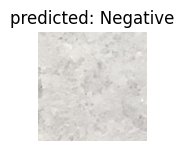

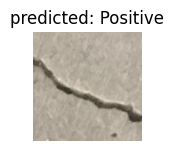

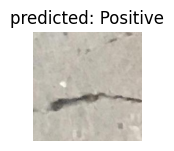

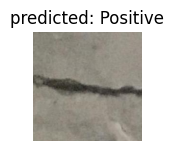

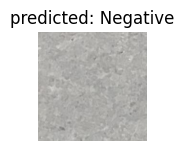

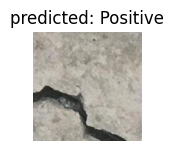

In [39]:
base_model = train_model(resnet50, criterion, optimizer, exp_lr_scheduler, num_epochs=6)
visualize_model(base_model)
plt.show()

## Inference

In [40]:
save_path = "model.pth"
torch.save(base_model.state_dict(), save_path)

In [16]:
import torch
import torch.nn as nn
import torchvision.models as models
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

idx_to_class = {0:'Negative', 1:'Positive'}


# Load the saved model for immediate prediction
# Define the model architecture
resnet50_loaded = models.resnet50()
fc_inputs_loaded = resnet50_loaded.fc.in_features
resnet50_loaded.fc = nn.Sequential(
    nn.Linear(fc_inputs_loaded, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 2)
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)


# Load the saved state dictionary
resnet50_loaded.load_state_dict(torch.load('model.pth', map_location=device))
# Set the model to evaluation mode
resnet50_loaded.eval()

# Now you can use resnet50_loaded for immediate prediction


cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
def predict(model, test_image, print_class = False):
     # it uses the model to predict on test_image...
    transform = chosen_transforms['val']
     
    test_image_tensor = transform(test_image)
    # if torch.cuda.is_available(): # checks if we have a gpu available
    #     print("cuda")
    #     test_image_tensor = test_image_tensor.view(1, 3, 227, 227).cuda()
    # else:
        # print("CPU")
    test_image_tensor = test_image_tensor.view(1, 3, 227, 227)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        # this computes the output of the model
        out = model(test_image_tensor)
        # this computes the probability of each classes.
        ps = torch.exp(out)
        # we choose the top class. That is, the class with highest probability
        topk, topclass = ps.topk(1, dim=1)
        class_name = idx_to_class[topclass.cpu().numpy()[0][0]]
        if print_class:
            print("Output class :  ", class_name)
    return class_name

In [4]:
def predict_on_crops(input_image, height=227, width=227, save_crops = False):
    im = cv2.imread(input_image)
    imgheight, imgwidth, channels = im.shape
    k=0
    output_image = np.zeros_like(im)
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            a = im[i:i+height, j:j+width]
            ## discard image cropss that are not full size
            # predicted_class = predict(base_model,Image.fromarray(a))
            
            predicted_class = predict(resnet50_loaded,Image.fromarray(a))
            ## save image
            file, ext = os.path.splitext(input_image)
            image_name = file.split('/')[-1]
            folder_name = 'out_' + image_name
            ## Put predicted class on the image
            if predicted_class == 'Positive':
                color = (0,0, 255)
            else:
                color = (0, 255, 0)
            cv2.putText(a, predicted_class, (50,50), cv2.FONT_HERSHEY_SIMPLEX , 0.7, color, 1, cv2.LINE_AA) 
            b = np.zeros_like(a, dtype=np.uint8)
            b[:] = color
            add_img = cv2.addWeighted(a, 0.9, b, 0.1, 0)
            ## Save crops
            if save_crops:
                if not os.path.exists(os.path.join('real_images', folder_name)):
                    os.makedirs(os.path.join('real_images', folder_name))
                filename = os.path.join('real_images', folder_name,'img_{}.png'.format(k))
                cv2.imwrite(filename, add_img)
            output_image[i:i+height, j:j+width,:] = add_img
            k+=1
    ## Save output image
    cv2.imwrite(os.path.join('real_images','predictions', folder_name+ '.jpg'), output_image)
    return output_image

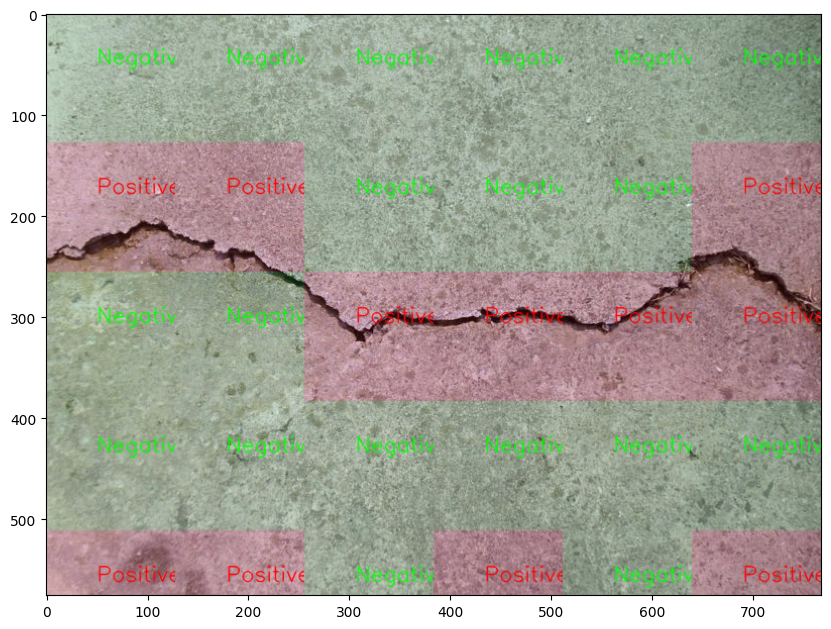

In [17]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('real_images/concrete_crack7.jpg', 128, 128)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

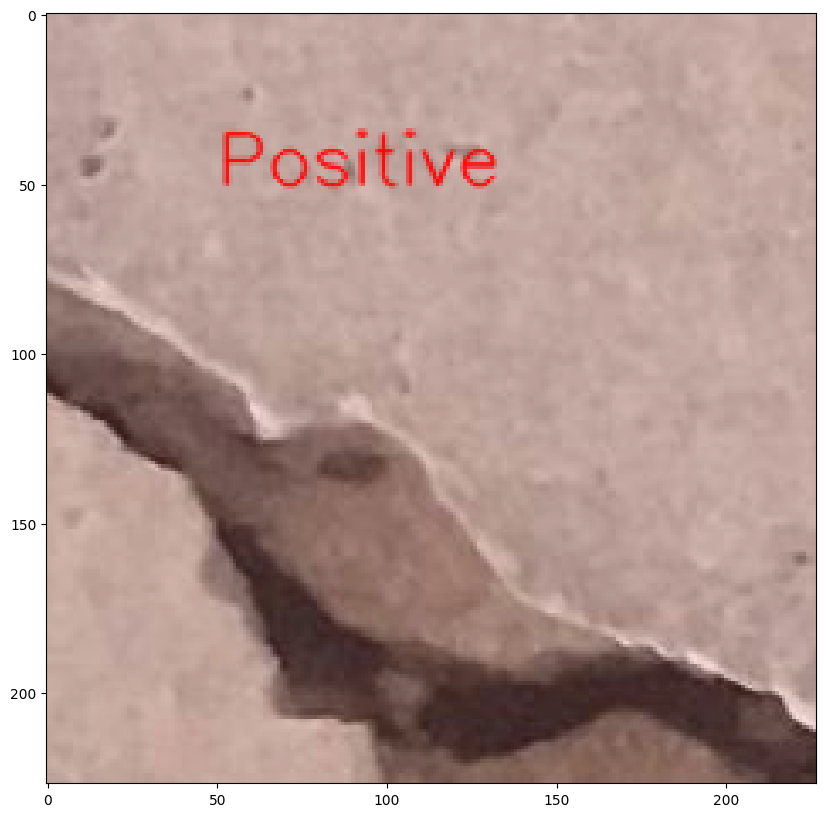

In [99]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('real_images/concrete_crack3.jpg')
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

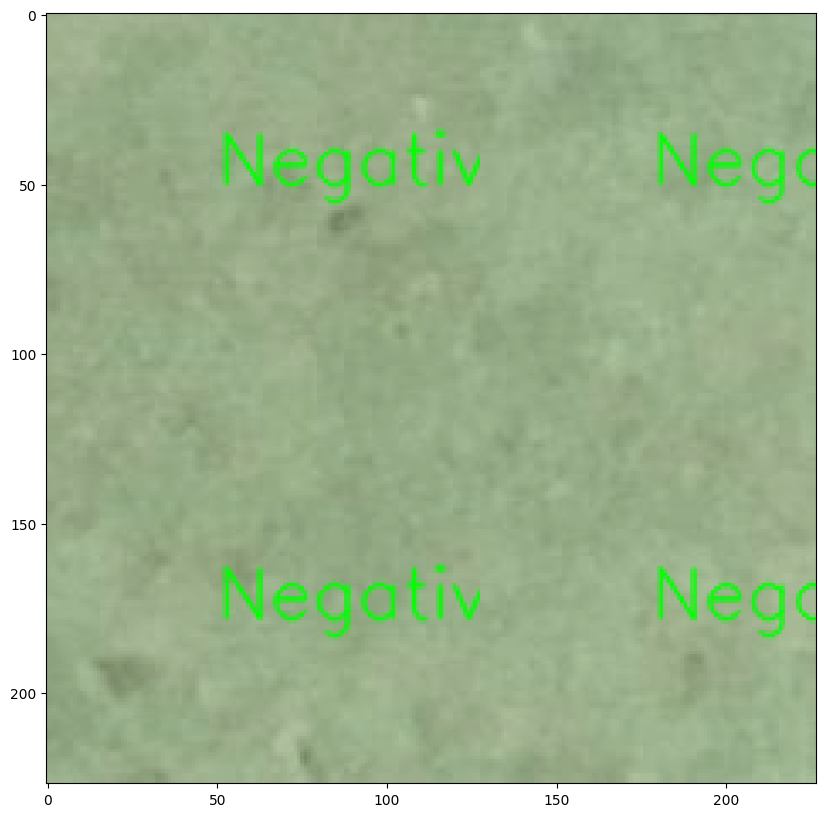

In [34]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('real_images/concrete_crack2.jpg',128,128)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

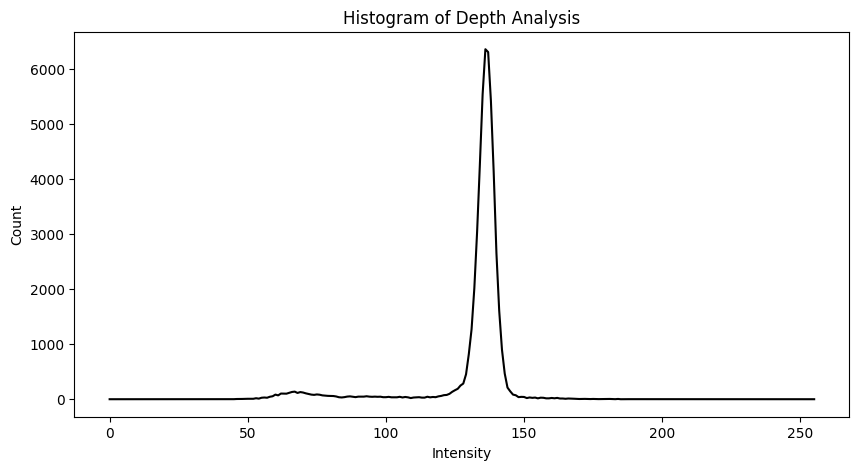

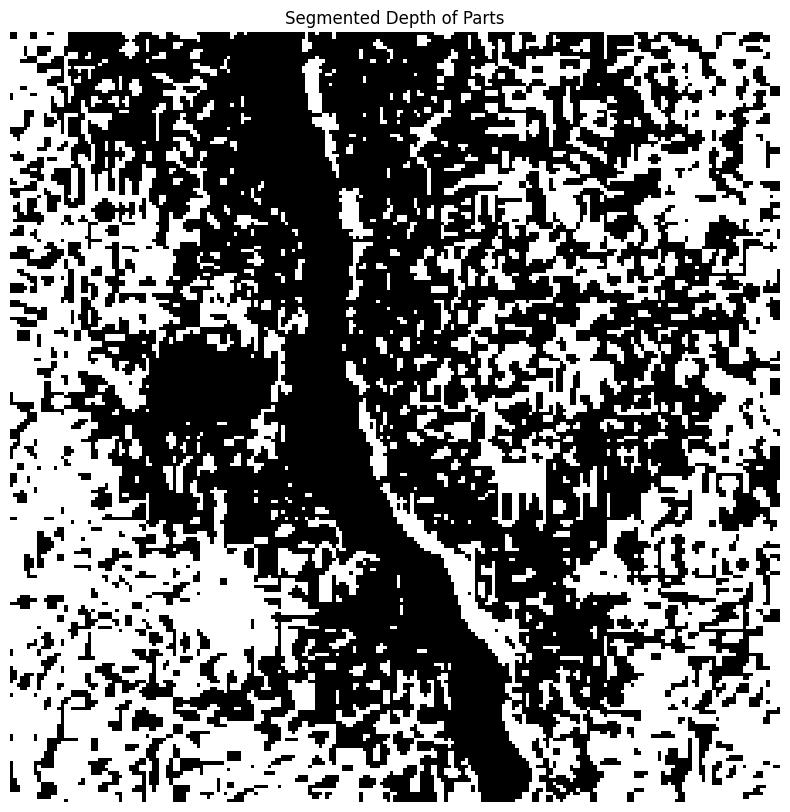

Intensity of darkest part: 136
Estimated depth of darkest part: 13.600000000000001 mm


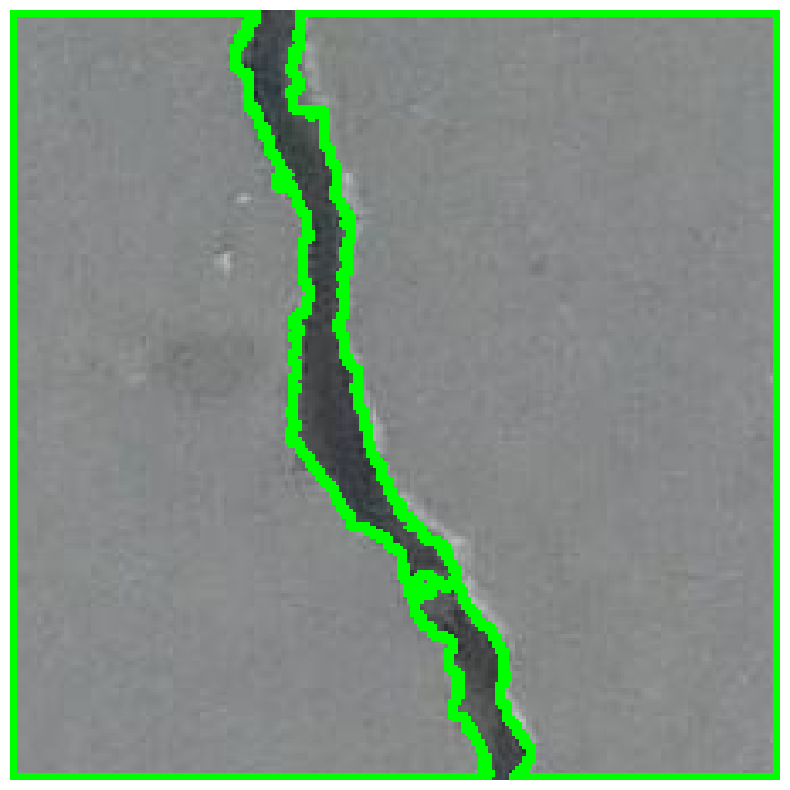

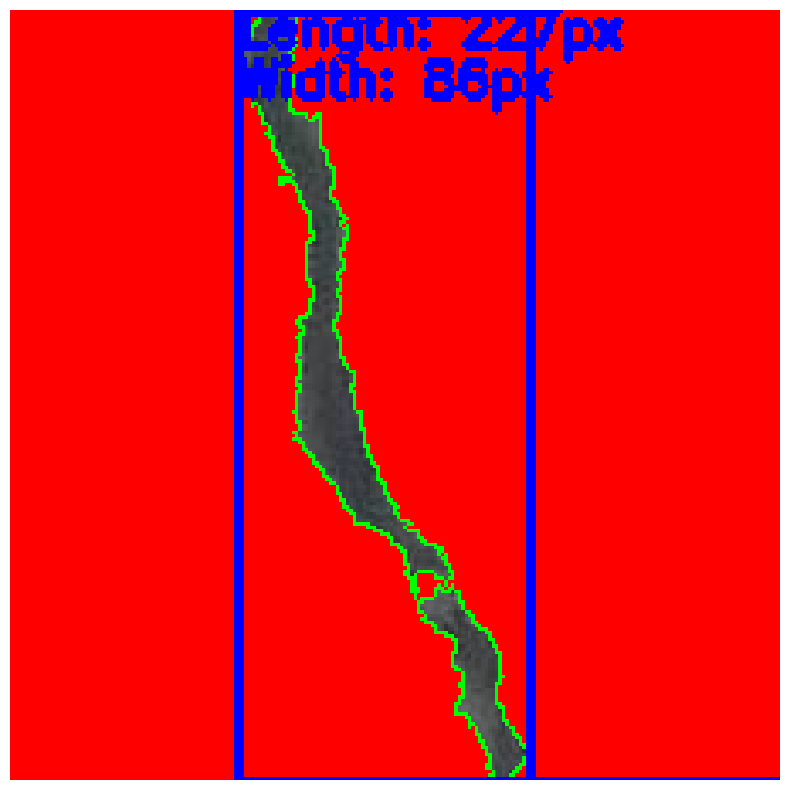

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
image = cv2.imread('real_images/concrete_crack1.jpg')

# Convert the image to grayscale
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Calculate the histogram of the grayscale image
histogram = cv2.calcHist([grayscale_image], [0], None, [256], [0, 256])

# Find the intensity value with the highest count (darkest part)
darkest_intensity = np.argmax(histogram)

# Display the histogram
plt.figure(figsize=(10, 5))
plt.plot(histogram, color='black')
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title('Histogram of Depth Analysis')
plt.show()

# Apply a simple threshold to segment the darkest parts of the image
_, binary_image = cv2.threshold(grayscale_image, darkest_intensity, 255, cv2.THRESH_BINARY)

# Display the segmented image
plt.figure(figsize=(10, 10))
plt.imshow(binary_image, cmap='gray')
plt.axis('off')
plt.title('Segmented Depth of Parts')
plt.show()

# Assuming a linear relationship between intensity and depth (for demonstration)
# You may need to calibrate this relationship based on your specific application
# This is just a hypothetical example
darkest_depth_mm = darkest_intensity * 0.1  # Arbitrary conversion factor

print("Intensity of darkest part:", darkest_intensity)
print("Estimated depth of darkest part:", darkest_depth_mm, "mm")




# Threshold the image to get the crack area
_, thresholded = cv2.threshold(grayscale_image, 100, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the contour with the longest length
contour_length = max(contours, key=cv2.contourArea)
cv2.drawContours(image, [contour_length], -1, (0, 255, 0), 2)

# Find the bounding rectangle of the contour
(x, y, w, h) = cv2.boundingRect(contour_length)

# Display the processed image
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()




# Threshold the image to get the crack area
_, thresholded = cv2.threshold(grayscale_image, 100, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the contour with the longest length
contour_length = max(contours, key=cv2.contourArea)
cv2.drawContours(image, [contour_length], -1, (0, 255, 0), 2)

# Create a mask of the green contour
mask = np.zeros_like(grayscale_image)
cv2.drawContours(mask, [contour_length], -1, 255, cv2.FILLED)

# Invert the mask
mask_inv = cv2.bitwise_not(mask)

# Color the parts not in the green as red
red_parts = cv2.bitwise_and(image, image, mask=mask_inv)
red_parts[np.where((red_parts == [0,0,0]).all(axis=2))] = [0,0,255]

# Find contours of non-red parts
non_red_contours, _ = cv2.findContours(mask_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Iterate through each contour
for contour in non_red_contours:
    # Calculate bounding box
    x, y, w, h = cv2.boundingRect(contour)
    # Draw bounding box
    cv2.rectangle(red_parts, (x, y), (x + w, y + h), (255, 0, 0), 2)
    # Calculate length
    length = max(w, h)
    # Draw line indicating length
    cv2.line(red_parts, (x + w, y + h), (x + w + length, y + h), (255, 0, 0), 2)
    # Write length and width on image
    cv2.putText(red_parts, f'Length: {length}px', (x, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    cv2.putText(red_parts, f'Width: {min(w, h)}px', (x, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Display the processed image
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(red_parts, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
